# Our Interactive Model

## Importing necessary tools

In [7]:
!pip install ortools
from __future__ import print_function
from ortools.sat.python import cp_model as cp
import math 

#for visualization
import numpy as np
import matplotlib.pyplot as plt
import sys
from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, Dropdown

## Definition of model parameters

In [8]:
# ensure that all inputs are of a type that can be used as a parameter
def get_valid_integer_input(prompt):
    while True:
        try:
            value = int(input(prompt))
            return value
        except ValueError:
            print("Invalid input. Please enter an integer and try again.")

# definition of the two router types and their respective specifications in terms of reach
def wifi_router_selection(frequency):
    global min_distance, sw, mw, bw, c, h
    if  frequency == "2.4GHz":
        min_distance = 91
        # Set other parameters based on the chosen option
        sw = 4.2
        mw = 7.5
        bw = 11.7
        c = 18.8
    elif frequency == "5GHz":
        min_distance = 30
        # Set other parameters based on the chosen option
        sw = 1.8
        mw = 2.6
        bw = 5
        c = 6.6

# Dropdown options for frequency selection
frequency_options = ["2.4GHz","5GHz"]

# Using interact to create the dropdown menu
@interact(frequency=Dropdown(options=frequency_options, description="WiFi Router:"))
def select_frequency(frequency):
    wifi_router_selection(frequency)

interactive(children=(Dropdown(description='WiFi Router:', options=('2.4GHz', '5GHz'), value='2.4GHz'), Output…

In [9]:
# Get user input for other parameters
l_input = input("Enter an integer for the length of a room (default: 4): ")
l = int(l_input) if l_input else 4
w_input = input("Enter an integer for the width of a room (default: 4): ")
w = int(w_input) if w_input else 4
h_input = input("Enter an integer for the heights of a room (default: 3): ")
h = int(h_input) if h_input else 3
f_input = input("Enter an integer number of floors (default: 5): ")
f = int(f_input) if f_input else 5
s_input = input("Enter an integer number of apartments in x, y in the building (default: 3): ")
s = int(s_input) if s_input else 3
hd_input = input("Enter an integer for the distance between house blocks (default: 10): ")
hd = int(hd_input) if hd_input else 10
ac_input = input("Enter an integer for the # of apartment complexes next to another (default: 2): ")
ac = int(ac_input) if ac_input else 2

#number of apartment complexes 
s= 2*s*ac

# Calculate num_blocks based on user input
num_blocks = s*s*f #number of sections on one length (x or y axis) -> we have three apartments, but each apartment is divided into 4 sections/rooms (2 per axis)

## Distance matrix calculation with constraints of all wall sizes

In [10]:
#Defining the model
model = cp.CpModel()

#calculating the distance between all rooms
def euclidean_distance(a, b):
  distance = math.sqrt(sum([(a[i] - b[i])**2 for i in range(len(a))]))   #general equation to calculate distance between two points in 3 dimensions
  diffz = abs(a[0] - b[0])   #distance in z direction
  diffx = abs(a[1] - b[1])   #distance in x direction
  diffy = abs(a[2] - b[2])   #distance in y direction

    #ceiling effect
  if diffz > 0:
    distance += (diffz/h)*c     #add distance for every ceiling/floor that we pass through
    
    #small wall effect
  if diffx > 0:
    distance += (diffx/l)*sw    #add distance for every small wall that we pass through
  if diffy > 0:
    distance += (diffy/w)*sw    #add distance for every small wall that we pass through
    
    # => comments on the right
    #medium wall effect  
  if (diffx/l) % 2 == 0:                                                                                                                #if the departments are a multiple of 2 apart from each other
    distance += ((diffx/l)//2) * mw                                                                                                     #then add how many multiples of 2 the department has times the thickness of the apartment wall
  else:
    if (a[1]<b[1] and (a[1]/l)%2==0) or (b[1]<a[1] and (b[1]/l)%2==0):                                                                  #if departments are uneven number apart and the lower indicated apartment is a multiple of 2
        distance += ((diffx/l)//2) * (mw-sw)                                                                                            #add multiple of 2 medium walls and subtract thin walls instead
    else:
        distance += ((diffx/l)//2) * (mw-sw) + (mw-sw)                                                                                  #otherwise add the same plus one additional medium wall

  if (diffy/w) % 2 == 0:                                                                                                                #if the departments are a multiple of 2 apart from each other
    distance += ((diffy/w)//2) * mw                                                                                                     #then add how many multiples of 2 the department has times the thickness of the apartment wall
  else:
    if (a[2]<b[2] and (a[2]/w)%2==0) or (b[2]<a[2] and (b[2]/w)%2==0):                                                                  #if departments are uneven number apart and the lower indicated apartment is a multiple of 2
        distance += ((diffy/w)//2) * (mw-sw)                                                                                            #add multiple of 2 medium walls and subtract thin walls instead
    else:
        distance += ((diffy/w)//2) * (mw-sw) + (mw-sw)                                                                                  #otherwise add the same plus one additional medium wall

    #big wall effect for only 1 or 4 (2x2) buildings
  if (a[1]/l < 6 and b[1]/l >= 6) or (a[1]/l > 6 and b[1]/l <= 6):   #if both points are on one half of the spectrum (above or below 6)
    distance += 2*bw + hd - sw - mw                               #add the two big outside walls and the distance between the buildings and subtract a small and medium wall
    
  if (a[2]/w < 6 and b[2]/w >= 6) or (a[2]/w > 6 and b[2]/w <= 6):   #if both points are on one half of the spectrum (above or below 6)
    distance += 2*bw + hd - sw - mw                               #add the two big outside walls and the distance between the buildings and subtract a small and medium wall        
  return distance
'''
This is a more complex and flexible way of calculating big walls, but takes a lot more computational time, which is why we do not use it here.
    #big wall effect
  if (diffx/l) // (s*2) > 0:                                                                                                            # if both points are further apart than number of apartments on one axis in one building
    if (a[1]<b[1] and (a[1] % (s*2)) < ((s*2)-((diffx/l) % (s*2)))) or (b[1]<a[1] and (b[1] % (s*2)) < ((s*2)-((diffx/l) % (s*2)))):    # check location of lower number -> looking at its location in 1 building find the split in the building according to the distance between both points
        distance += ((diffx/l) // (s*2)) * (2*bw + hd - sw - mw)                                                                        # if on the left of threshold add amount of big wall distance according to lower number of possible big walls in between
    else:                                                     
        distance += ((diffx/l) // (s*2)) * (2*bw + hd - sw - mw) + (2*bw + hd - sw - mw)                                                # if on the right of threshold add amount of big wall distance according to higher number of possible big walls in between
    
  if (diffy/w) // (s*2) > 0:                                                                                                            # if both points are further apart than number of apartments on one axis in one building
    if (a[2]<b[2] and (a[2] % (s*2)) < ((s*2)-((diffy/w) % (s*2)))) or (b[2]<a[2] and (b[2] % (s*2)) < ((s*2)-((diffy/w) % (s*2)))):    # check location of lower number -> looking at its location in 1 building find the split in the building according to the distance between both points
        distance += ((diffy/w) // (s*2)) * (2*bw + hd - sw - mw)                                                                        # if on the left of threshold add amount of big wall distance according to lower number of possible big walls in between
    else:                                                     
        distance += ((diffy/w) // (s*2)) * (2*bw + hd - sw - mw) + (2*bw + hd - sw - mw)    # if on the right of threshold add amount of big wall distance according to higher number of possible big walls in between
  return distance
'''
   

'\nThis is a more complex and flexible way of calculating big walls, but takes a lot more computational time, which is why we do not use it here.\n    #big wall effect\n  if (diffx/l) // (s*2) > 0:                                                                                                            # if both points are further apart than number of apartments on one axis in one building\n    if (a[1]<b[1] and (a[1] % (s*2)) < ((s*2)-((diffx/l) % (s*2)))) or (b[1]<a[1] and (b[1] % (s*2)) < ((s*2)-((diffx/l) % (s*2)))):    # check location of lower number -> looking at its location in 1 building find the split in the building according to the distance between both points\n        distance += ((diffx/l) // (s*2)) * (2*bw + hd - sw - mw)                                                                        # if on the left of threshold add amount of big wall distance according to lower number of possible big walls in between\n    else:                                                  

## Running the optimization model

In [11]:
#create model of room location
points = [(i, j, k) for i in range(f) for j in range(s) for k in range(s)]     #simple point matrix with distance 1 between points
selected_points = [(i*h, j*l, k*w) for i, j, k in points if i in list(range(f)) and j in list(range(s)) and k in list(range(s))]   #adapted point matrix according to real distances

#create distance matrix between all rooms
distance = [
    [euclidean_distance(a, b) for b in selected_points] for a in selected_points
]


# define decision variables - coverage of router x=1 if covered
x = [model.NewIntVar(0, 1, "x[%i]" % i) for i in range(num_blocks)] #decision, where we put routers (1 if we use router in room, 0 if not)
z = model.NewIntVar(0, num_blocks, "z") #total number of routers used (want to minimize)

#objective to minimize: 
model.Add(z == sum(x))

#constraints
for i in range(num_blocks):
        model.Add(sum([x[j] for j in range(num_blocks) if distance[i][j] <= min_distance]) >= 1)


model.Minimize(z)
solver = cp.CpSolver()
status = solver.Solve(model)
if status == cp.OPTIMAL:
  print("z:", solver.Value(z))
  print("x:", [solver.Value(x[i]) for i in range(num_blocks)])
  print("NumConflicts:", solver.NumConflicts())
  print("NumBranches:", solver.NumBranches())
print (len(x))

z: 4
x: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

## Visualization of results

The following rooms need to be equipped with a WiFi router:
Room 327
Room 334
Room 394
Room 411


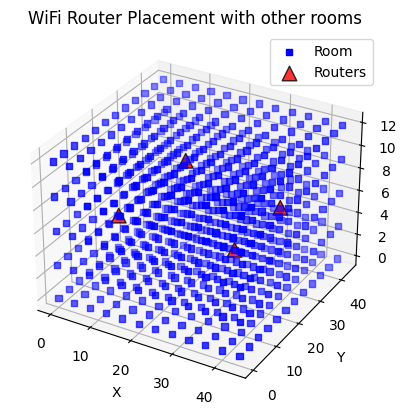

Here is a visualization of only the router placements:


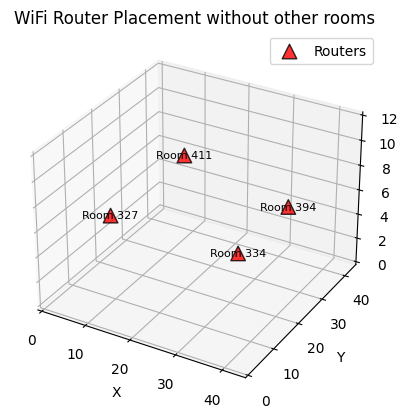

In [12]:
# Extract the coordinates of selected points and router placements
coordinates = np.array([list(point) for point in selected_points])
router_placements = np.array([solver.Value(x[i]) for i in range(num_blocks)])

# Separate the router placements into individual coordinates
router_coordinates = coordinates[router_placements == 1]
#display(router_coordinates)
rotated_router_coordinates = np.copy(router_coordinates)
rotated_router_coordinates[:,0] = router_coordinates[:,2]
rotated_router_coordinates[:,1] = router_coordinates[:, 1]
rotated_router_coordinates[:,2] = router_coordinates[:, 0]
#display(rotated_router_coordinates)
# Rotate the coordinates and adjust the position
rotated_coordinates = np.copy(coordinates)
rotated_coordinates[:, 0], rotated_coordinates[:, 1], rotated_coordinates[:, 2] = coordinates[:, 2], coordinates[:, 1], coordinates[:, 0]

ap_list = []
print("The following rooms need to be equipped with a WiFi router:")
for value in rotated_router_coordinates:
    index = np.where(np.all(rotated_coordinates == value, axis=1))[0]
    index += 1
    apartment_str = "Room " + str(index.item())
    print(apartment_str)
    ap_list.append(apartment_str)

# Plotting the 3D visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# Plot all room coordinates
ax.scatter(rotated_coordinates[:, 0],rotated_coordinates[:, 1],rotated_coordinates[:, 2], c='blue', marker='s', label='Room')

# Plot router coordinates
ax.scatter(rotated_router_coordinates[:, 0], rotated_router_coordinates[:, 1], rotated_router_coordinates[:, 2], c='red', marker='^', s=110, alpha=0.8, edgecolors='black', label='Routers')

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("WiFi Router Placement with other rooms")
ax.legend()

plt.show()

print("Here is a visualization of only the router placements:")

# Plotting the 3D visualization without all rooms
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot router coordinates
ax.scatter(rotated_router_coordinates[:, 0], rotated_router_coordinates[:, 1], rotated_router_coordinates[:, 2], c='red', marker='^', s=110, alpha=0.8, edgecolors='black', label='Routers')

# Label each point with corresponding names
for i, name in enumerate(ap_list):
    ax.text(rotated_router_coordinates[i, 0], rotated_router_coordinates[i, 1], rotated_router_coordinates[i, 2], name, fontsize=8, ha='center', va='center')
    
# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("WiFi Router Placement without other rooms")
ax.legend()

# Adjust the axes limits
x_min = min(rotated_coordinates[:, 0])
x_max = max(rotated_coordinates[:, 0])
y_min = min(rotated_coordinates[:, 1])
y_max = max(rotated_coordinates[:, 1])
z_min = min(rotated_coordinates[:, 2])
z_max = max(rotated_coordinates[:, 2])
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

plt.show()